In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.svm import SVC

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

# import the functions from the evaluate_models.py

import sys
import os

# import own modules
sys.path.append("..")  # Adds higher directory to python modules path.
from scripts import evaluate_models as em

#for clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import time
import scipy.cluster.hierarchy as sch
from sklearn.neighbors import NearestNeighbors


plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')


In [2]:
# path to csv file
path_df = os.path.join("..", "data", "df_deepgaze2e.csv")

# get features - or recalculate
recalculate_df = False
if os.path.isfile(path_df) and not recalculate_df:
    df = pd.read_csv(path_df)
else:
    df = ft.get_features()
    df.to_csv(path_df, index=False)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=['img', 'sp_idx'])

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7598 instances and 307 columns
 -> there are 307 numerical columns
 -> there are 0 categoricals columns


In [6]:
df.columns

Index(['asd', 'sp_fix_count', 'sp_fix_duration_ms_total',
       'sp_fix_duration_ms_mean', 'sp_fix_duration_ms_var', 'sp_len_px_total',
       'sp_saccade_amplitude_px_mean', 'sp_saccade_amplitude_px_var',
       'sp_distance_to_centre_px_mean', 'sp_distance_to_centre_px_var',
       ...
       'obj_t_rel_on_machine_obj', 'obj_n_fix_dummy_obj',
       'obj_t_abs_on_dummy_obj', 'obj_t_rel_on_dummy_obj',
       'obj_n_fix_butterfly_obj', 'obj_t_abs_on_butterfly_obj',
       'obj_t_rel_on_butterfly_obj', 'obj_n_fix_gorilla_obj',
       'obj_t_abs_on_gorilla_obj', 'obj_t_rel_on_gorilla_obj'],
      dtype='object', length=307)

In [7]:
df2 = df[[col for col in df.columns if "obj_t_rel" in col]]

In [8]:
df2.head()

,obj_t_rel_on_face,obj_t_rel_on_animate,obj_t_rel_on_inanimate,obj_t_rel_on_background,obj_t_rel_on_person_obj,obj_t_rel_on_deer_obj,obj_t_rel_on_statue_obj,obj_t_rel_on_car_obj,obj_t_rel_on_stop sign_obj,obj_t_rel_on_cat_obj,...,obj_t_rel_on_icecream_obj,obj_t_rel_on_banana_obj,obj_t_rel_on_knife_obj,obj_t_rel_on_meat_obj,obj_t_rel_on_bread_obj,obj_t_rel_on_leopard_obj,obj_t_rel_on_machine_obj,obj_t_rel_on_dummy_obj,obj_t_rel_on_butterfly_obj,obj_t_rel_on_gorilla_obj
id,,,,,,,,,,,,,,,,,,,,,
asd_001_00,0.211230,0.478610,0.0,0.521390,0.478610,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
asd_001_01,0.294811,0.562107,0.0,0.437893,0.562107,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
asd_001_02,0.114007,0.410641,0.0,0.589359,0.410641,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
asd_001_03,0.120336,0.423274,0.0,0.576726,0.423274,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
asd_001_04,0.000000,0.263963,0.0,0.736037,0.263963,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df2.shape

(7598, 95)

In [27]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

from scipy.cluster.hierarchy import linkage

RecursionError: maximum recursion depth exceeded while calling a Python object

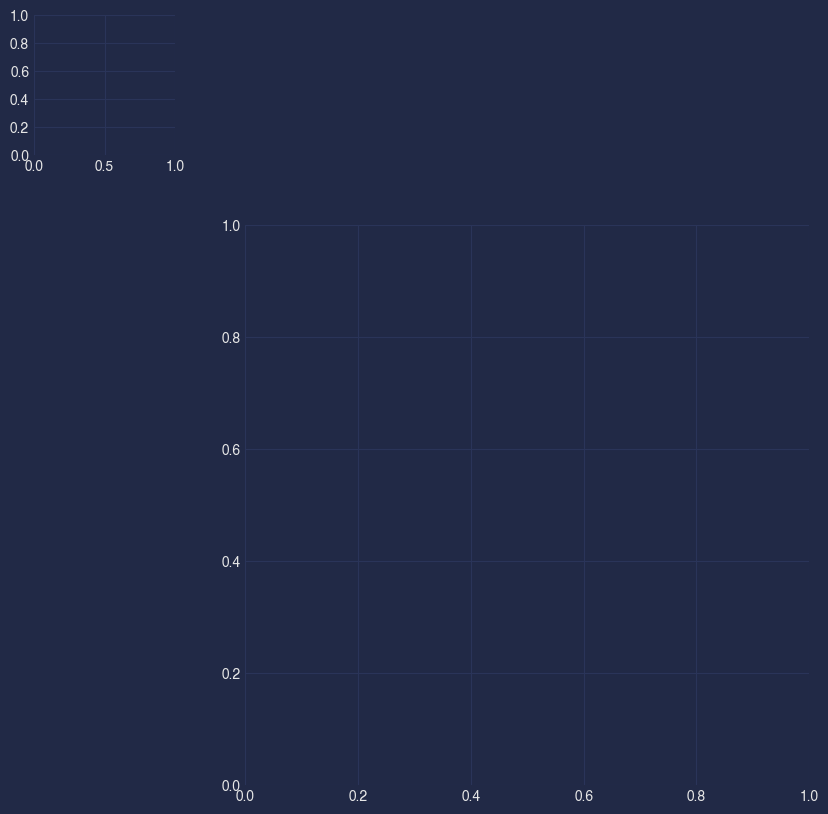

In [28]:
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns

# Compute the Jaccard distance matrix
jaccard_dist = pdist(df2.values, metric='jaccard')
jaccard_linkage = linkage(jaccard_dist, method='average')

# Visualize the clustering result as a dendrogram
sns.clustermap(df2, row_cluster=True, col_cluster=False, cmap='viridis', row_linkage=jaccard_linkage)



In [13]:
#kmeans clustering

k = 2
kmeans = KMeans(n_clusters=k)
cluster_labels = kmeans.fit_predict(df2)

In [17]:
# defining a utility function for testing the clustering algorithms
def plot_clusters(df2, algorithm, kwds):
    # cluster the data while taking the time the process needs 
    start_time = time.time()
    labels = algorithm(**kwds).fit_predict(df2)
    end_time = time.time()
    
    # defining the colors for visual representation
    palette = sns.color_palette('bright', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    # plotting the data, removing the axis and adding title and time 
    plt.scatter(df2.T[0], df2.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

In [18]:
plot_clusters(df2, KMeans, {'n_clusters':2})

KeyError: 0

In [ ]:
plot_clusters(data, KMeans, {'n_clusters':6})